# MVP Color Verification in Python (WIP)

This Jupyter Notebook is a work in progress for the expected implementation of the Color Verification in Python.

## Global Libraries

In [1]:
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage.color import deltaE_ciede2000, rgb2lab
from sklearn.cluster import KMeans
import time
from typing import Tuple, Dict, Union

### CV2 vs PIL performance

In [2]:
# OpenCV
start = time.time()
img_cv2 = cv2.imread('healthappscreenshot.png')
end = time.time()
print(f'OpenCV load time: {end - start} s')

OpenCV load time: 0.019745588302612305 s


In [3]:
# Pillow
start = time.time()
img_pil = Image.open('healthappscreenshot.png')
img_np = np.array(img_pil)
end = time.time()
print(f'Pillow load time: {end - start} s')

Pillow load time: 0.04184889793395996 s


CV2 is faster in terms of image loading, so we are going to stick with this tool in order to read the images and convert them to RGB.

# Simple flow according to MVP:

## 1. Screenshot is taken and saved

We assume this step was already done.

## 2. Image preprocessing

In [4]:
# Loading image with CV2 and converting to RGB
screenshot = cv2.imread('healthappscreenshot.png')
screenshot_rgb = cv2.cvtColor(screenshot, cv2.COLOR_BGR2RGB)

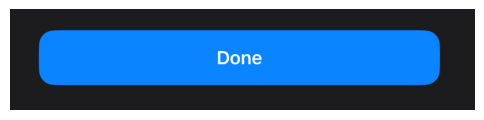

In [5]:
# ROI extraction

def extract_roi(image_rgb, x, y, width, height):
    """
    Extract the ROI (Region of Interest) of the image using pixel 
    coordinates from Abstract (375x812), auto-converted to the actual 
    resolution of the screenshot

    Args:
        image_rgb (np.ndarray): Screenshot in RGB format
        x (float): X position of element from Abstract (in px)
        y (float): Y position of element from Abstract (in px)
        width (float): Width of element in px
        height (float): Height of element in px

    Returns:
        np.ndarray: Cropped image region (RGB)
    """
    h, w, _ = image_rgb.shape
    x1 = int((x / 375) * w)
    x2 = int(((x + width) / 375) * w)
    y1 = int((y / 812) * h)
    y2 = int(((y + height) / 812) * h)
    return image_rgb[y1:y2, x1:x2]

extracted_roi = extract_roi(image_rgb=screenshot_rgb, 
                            x=5, y=710, width=1500, height=80)

plt.figure(figsize=(6, 2))
plt.imshow(extracted_roi)
plt.axis('off')
plt.show()

# 3. Color Detection

In [6]:
def rgb_to_hex(rgb):
    """
    Convert an RGB color tuple or array to a hexadecimal color string

    Args:
        rgb (Union[np.ndarray, Tuple[float, float, float]]): The RGB color 
                                                             as a NumPy array or tuple

    Returns:
        str: Hexadecimal representation of the color
    """
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]), int(rgb[1]), int(rgb[2]))

def hex_to_rgb(hex_val):
    """
    Convert a hexadecimal color string to an RGB tuple

    Args:
        hex_val (str): The hex color string (e.g., '#35c759')

    Returns:
        Tuple[int, int, int]: Corresponding RGB values in a tuple
    """
    hex_val = hex_val.lstrip('#')
    return tuple(int(hex_val[i:i+2], 16) for i in (0, 2, 4))

def calculate_delta_e(rgb1, rgb2):
    """
    Calculate Delta-E CIEDE2000 between two RGB colors using skimage 
    
    Args:
        rgb1, rgb2 (array-like): RGB values [0–255] or np arrays

    Returns:
        float: Delta-E distance
    """
    rgb1_arr = np.array([[rgb1]], dtype=np.uint8) / 255.0
    rgb2_arr = np.array([[rgb2]], dtype=np.uint8) / 255.0

    lab1 = rgb2lab(rgb1_arr)
    lab2 = rgb2lab(rgb2_arr)

    delta = deltaE_ciede2000(lab1, lab2)
    return float(delta[0][0])

def check_button_color_dominant(
    cropped_rgb,
    expected_hex,
    mode='dark',
    method='delta-e',
    threshold=2.0,
    n_clusters=3
):
    """
    Detect the dominant color in a cropped image and compare it to the expected HEX.

    Args:
        cropped_rgb (np.ndarray): The cropped button image in RGB format.
        expected_hex (str): The expected color in hexadecimal format.
        mode (str): 'light' or 'dark' - influences background exclusion logic.
        method (str): 'euclidean' or 'delta-e' for comparison.
        threshold (float): Tolerance threshold for matching.
        n_clusters (int): Number of clusters for KMeans.

    Returns:
        dict: Contains detected color info and match result.
    """
    expected_rgb = np.array(hex_to_rgb(expected_hex))
    pixels = cropped_rgb.reshape(-1, 3)

    # Define background filter thresholds based on mode
    if mode == 'light':
        background_color = np.array([255, 255, 255])
    else:  # dark mode
        background_color = np.array([28, 28, 30])  # #1c1c1e

    # Filter: remove pixels too close to background
    mask = np.linalg.norm(pixels - background_color, axis=1) > 15
    filtered_pixels = pixels[mask]

    if len(filtered_pixels) == 0:
        return {
            'Dominant RGB': background_color,
            'Detected HEX': rgb_to_hex(background_color),
            'Expected HEX': expected_hex,
            'Distance to Expected': float('inf'),
            'Distance Method': method,
            'Mode': mode,
            'Match Result': 'No valid foreground pixels'
        }

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    kmeans.fit(filtered_pixels)
    counts = np.bincount(kmeans.labels_)
    dominant_rgb = kmeans.cluster_centers_[np.argmax(counts)]

    # Compare with expected using selected method
    if method == 'delta-e':
        distance = calculate_delta_e(dominant_rgb, expected_rgb)
        match = 'Matched' if distance < threshold else 'Not matched'
    else:
        distance = np.linalg.norm(dominant_rgb - expected_rgb)
        match = 'Matched' if distance < threshold else 'Not matched'

    return {
        'Dominant RGB': dominant_rgb.astype(int),
        'Detected HEX': rgb_to_hex(dominant_rgb),
        'Expected HEX': expected_hex,
        'Distance to Expected': round(float(distance), 2),
        'Distance Method': method,
        'Mode': mode,
        'Match Result': match
    }

In [7]:
result_delta_e = check_button_color_dominant(
    cropped_rgb=extracted_roi,
    expected_hex="#0a84ff",  # iOS Blue (Dark Mode)
    mode="dark",
    method="delta-e",
    threshold=2.0
)

print(result_delta_e)

{'Dominant RGB': array([ 10, 132, 254]), 'Detected HEX': '#0a84fe', 'Expected HEX': '#0a84ff', 'Distance to Expected': 0.13, 'Distance Method': 'delta-e', 'Mode': 'dark', 'Match Result': 'Matched'}


In [8]:
result_euclidean = check_button_color_dominant(
    cropped_rgb=extracted_roi,
    expected_hex="#0a84ff",  # iOS Blue (Dark Mode)
    mode="dark",
    method="euclidean",
    threshold=2.0
)

print(result_euclidean)

{'Dominant RGB': array([ 10, 132, 254]), 'Detected HEX': '#0a84fe', 'Expected HEX': '#0a84ff', 'Distance to Expected': 0.12, 'Distance Method': 'euclidean', 'Mode': 'dark', 'Match Result': 'Matched'}
